# Task 3: Window Soft-Argmax Evaluation

This notebook evaluates the **Window Soft-Argmax** prediction method on:
- **3 Baseline Models**: DINOv2, DINOv3, SAM
- **3 Fine-Tuned Models**: Using .pth checkpoint files

## Key Improvements over Baseline (Argmax)
1. **Sub-pixel precision**: Instead of discrete argmax, we use soft-argmax for refinement
2. **Noise robustness**: Windowed approach reduces sensitivity to local similarity noise
3. **Better PCK at strict thresholds**: Most improvements visible at α=0.05 and α=0.10

## 1. Setup & Imports

In [1]:
# Clone repository and install dependencies (Colab only)
!rm -rf semantic-correspondance
!git clone https://github.com/MarcotteS/semantic-correspondance.git

import sys
sys.path.append('/content/semantic-correspondance/src')

Cloning into 'semantic-correspondance'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 216 (delta 0), reused 0 (delta 0), pack-reused 215 (from 1)
Receiving objects: 100% (216/216), 1.75 MiB | 4.68 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [2]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime
from collections import defaultdict
import pandas as pd

# Import from src
from dataset import SPairDataset, collate_fn_correspondence
from models import DINOv2Extractor, DINOv3Extractor, SAMExtractor
from correspondence import CorrespondenceMatcher
from correspondence_softargmax import WindowSoftArgmaxMatcher
from evaluation import CorrespondenceEvaluator
from analyzer import ResultsAnalyzer

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Download Dataset

In [13]:
# Download SPair-71k dataset
if not os.path.exists('SPair-71k'):
    !wget -q https://cvlab.postech.ac.kr/research/SPair-71k/data/SPair-71k.tar.gz
    !tar -xf SPair-71k.tar.gz
    print("Dataset downloaded and extracted!")
else:
    print("Dataset already exists.")

Dataset downloaded and extracted!


## 3. Configuration

In [14]:
# ========================================
# CONFIGURATION - Edit these paths
# ========================================

# Path to the dataset
DATA_PATH = '.'  # Path where SPair-71k was extracted

# Fine-tuned model checkpoints (.pth files)
# Set these paths to your fine-tuned model files
FINETUNED_CHECKPOINTS = {
    'dinov2_finetuned': '/content/drive/MyDrive/semantic-correspondance-project/checkpoints/dinov2_finetuned/last.pt',
    'dinov3_finetuned': '/content/drive/MyDrive/semantic-correspondance-project/checkpoints/dinov3_finetuned/last.pt',
    'sam_finetuned': '/content/drive/MyDrive/semantic-correspondance-project/checkpoints/sam_finetuned/last.pt',
}

# DINOv3 specific configuration
# You need to clone the dinov3 repo and get access to the checkpoint
DINOV3_REPO_DIR = 'dinov3'  # Path to cloned DINOv3 repo
# Change this line:
DINOV3_WEIGHTS = "dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth"

# SAM specific configuration
SAM_CHECKPOINT_PATH = 'sam_vit_b_01ec64.pth'

# Window Soft-Argmax parameters
WINDOW_SIZE = 5
TEMPERATURE = 0.1

# Evaluation parameters
IMAGE_SIZE_DINO = 224  # For DINOv2 and DINOv3 (must be multiple of 14 for v2, 16 for v3)
IMAGE_SIZE_SAM = 512   # For SAM
BATCH_SIZE = 16
NUM_WORKERS = 4

# Output directory
RESULTS_DIR = './results/task3_evaluation'

## 4. Helper Functions

In [5]:
def evaluate_model_simple(matcher, dataloader, desc="Evaluating"):
    """
    Evaluate correspondence matcher on a dataset.
    Returns metrics dictionary.
    """
    evaluator = CorrespondenceEvaluator(thresholds=[0.05, 0.10, 0.15, 0.20])
    matcher.extractor.model.eval()

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=desc):
            src_img = batch['src_img']
            trg_img = batch['trg_img']
            src_kps = batch['src_kps']

            pred_kps = matcher.find_correspondences(src_img, trg_img, src_kps)

            batch_size = src_img.shape[0]
            for b in range(batch_size):
                pred_kps_b = pred_kps[b]
                # Extract keypoint IDs correctly from collated batch
                kps_ids_b = batch['kps_ids'][b]
                batch_single = {
                    'trg_kps': batch['trg_kps'][b],
                    'pckthres': batch['pckthres'][b],
                    'n_pts': batch['n_pts'][b],
                    'kps_ids': kps_ids_b,
                    'pair_idx': batch['pair_idx'][b],
                    'category': batch['category'][b],
                }
                evaluator.update(pred_kps_b, batch_single)

    metrics = evaluator.get_metrics()
    evaluator.print_summary(metrics)
    return metrics


def load_finetuned_weights(model, checkpoint_path):
    """
    Load fine-tuned weights from a checkpoint file.
    Handles the checkpoint format from the training script.
    """
    if not os.path.exists(checkpoint_path):
        print(f"⚠️ Checkpoint not found: {checkpoint_path}")
        return False

    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Handle different checkpoint formats
    if 'model' in checkpoint:
        state_dict = checkpoint['model']
    elif 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint

    model.load_state_dict(state_dict)
    print(f"✅ Loaded fine-tuned weights from: {checkpoint_path}")

    if 'epoch' in checkpoint:
        print(f"   Epoch: {checkpoint['epoch'] + 1}")
    if 'meta' in checkpoint:
        print(f"   Training config: {checkpoint['meta']}")

    return True


def save_results(all_results, output_dir):
    """
    Save all evaluation results to JSON and generate comparison plots.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Save raw metrics
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    metrics_path = os.path.join(output_dir, f'metrics_{timestamp}.json')

    # Convert metrics to JSON-serializable format
    def to_json(obj):
        if isinstance(obj, dict):
            return {str(k): to_json(v) for k, v in obj.items()}
        elif isinstance(obj, (list, tuple)):
            return [to_json(v) for v in obj]
        elif isinstance(obj, (np.integer, np.floating)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, torch.Tensor):
            return obj.cpu().tolist()
        return obj

    with open(metrics_path, 'w') as f:
        json.dump(to_json(all_results), f, indent=2)

    print(f"✅ Results saved to: {metrics_path}")
    return metrics_path

## 5. Visualization Functions

In [6]:
def plot_model_comparison(all_results, save_path=None):
    """
    Create comparison bar chart for all models at different thresholds.
    """
    thresholds = [0.05, 0.10, 0.15, 0.20]
    model_names = list(all_results.keys())
    n_models = len(model_names)
    n_thresholds = len(thresholds)

    fig, ax = plt.subplots(figsize=(14, 8))

    x = np.arange(n_thresholds)
    width = 0.8 / n_models

    colors = plt.cm.tab10(np.linspace(0, 1, n_models))

    for i, (model_name, metrics) in enumerate(all_results.items()):
        pck_values = [metrics['overall'][t] for t in thresholds]
        offset = (i - n_models/2 + 0.5) * width
        bars = ax.bar(x + offset, pck_values, width, label=model_name, color=colors[i], alpha=0.8)

        # Add value labels
        for bar, val in zip(bars, pck_values):
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                   f'{val:.1f}', ha='center', va='bottom', fontsize=8, rotation=90)

    ax.set_xlabel('PCK Threshold (α)', fontsize=12)
    ax.set_ylabel('PCK (%)', fontsize=12)
    ax.set_title('Task 3: Window Soft-Argmax - Model Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'α={t:.2f}' for t in thresholds])
    ax.set_ylim([0, 100])
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_baseline_vs_finetuned(all_results, save_path=None):
    """
    Compare baseline vs fine-tuned models.
    """
    thresholds = [0.05, 0.10, 0.15, 0.20]

    # Separate baseline and fine-tuned
    baselines = {k: v for k, v in all_results.items() if 'finetuned' not in k.lower()}
    finetuned = {k: v for k, v in all_results.items() if 'finetuned' in k.lower()}

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot baselines
    ax1 = axes[0]
    for model_name, metrics in baselines.items():
        pck_values = [metrics['overall'][t] for t in thresholds]
        ax1.plot(thresholds, pck_values, marker='o', linewidth=2, markersize=8, label=model_name)
    ax1.set_xlabel('PCK Threshold (α)', fontsize=12)
    ax1.set_ylabel('PCK (%)', fontsize=12)
    ax1.set_title('Baseline Models (Soft-Argmax)', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 100])

    # Plot fine-tuned
    ax2 = axes[1]
    for model_name, metrics in finetuned.items():
        pck_values = [metrics['overall'][t] for t in thresholds]
        ax2.plot(thresholds, pck_values, marker='s', linewidth=2, markersize=8, label=model_name)
    ax2.set_xlabel('PCK Threshold (α)', fontsize=12)
    ax2.set_ylabel('PCK (%)', fontsize=12)
    ax2.set_title('Fine-Tuned Models (Soft-Argmax)', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 100])

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_per_category_comparison(all_results, threshold=0.10, save_path=None):
    """
    Compare per-category performance across models.
    """
    # Get all categories from first model
    first_model = list(all_results.values())[0]
    categories = sorted(first_model['per_category'].keys())

    model_names = list(all_results.keys())
    n_models = len(model_names)
    n_categories = len(categories)

    fig, ax = plt.subplots(figsize=(18, 8))

    x = np.arange(n_categories)
    width = 0.8 / n_models

    colors = plt.cm.tab10(np.linspace(0, 1, n_models))

    for i, (model_name, metrics) in enumerate(all_results.items()):
        pck_values = [metrics['per_category'].get(cat, {}).get(threshold, 0) for cat in categories]
        offset = (i - n_models/2 + 0.5) * width
        ax.bar(x + offset, pck_values, width, label=model_name, color=colors[i], alpha=0.8)

    ax.set_xlabel('Category', fontsize=12)
    ax.set_ylabel(f'PCK@{threshold:.2f} (%)', fontsize=12)
    ax.set_title(f'Per-Category Performance Comparison (PCK@{threshold:.2f})', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.set_ylim([0, 100])
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def create_summary_table(all_results):
    """
    Create a summary DataFrame comparing all models.
    """
    thresholds = [0.05, 0.10, 0.15, 0.20]

    data = []
    for model_name, metrics in all_results.items():
        row = {'Model': model_name}
        for t in thresholds:
            row[f'PCK@{t:.2f}'] = f"{metrics['overall'][t]:.2f}%"
        data.append(row)

    df = pd.DataFrame(data)
    return df

## 6. Load Dataset

In [15]:
# Load test dataset for DINO models
print("Loading SPair-71k test dataset for DINO...")
test_dataset_dino = SPairDataset(
    datapath=DATA_PATH,
    split='test',
    img_size=IMAGE_SIZE_DINO,
    category='all'
)

test_loader_dino = DataLoader(
    test_dataset_dino,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn_correspondence
)

print(f"Test dataset: {len(test_dataset_dino)} pairs")

Loading SPair-71k test dataset for DINO...
Loading SPair-71k test annotations...


100%|██████████| 12234/12234 [00:02<00:00, 5589.75it/s]


Test dataset: 12234 pairs


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 7. Evaluate Baseline Models with Window Soft-Argmax

### 7.1 DINOv2 Baseline

In [16]:
# Store all results
all_results = {}

print("="*70)
print("EVALUATING: DINOv2 Baseline + Window Soft-Argmax")
print("="*70)

# Initialize DINOv2 extractor
dinov2_extractor = DINOv2Extractor(model_name="dinov2_vitb14")

# Create Window Soft-Argmax matcher
dinov2_matcher = WindowSoftArgmaxMatcher(
    feature_extractor=dinov2_extractor,
    window_size=WINDOW_SIZE,
    temperature=TEMPERATURE
)

# Evaluate
metrics_dinov2 = evaluate_model_simple(dinov2_matcher, test_loader_dino, desc="DINOv2 Baseline")
all_results['DINOv2_SoftArgmax'] = metrics_dinov2

EVALUATING: DINOv2 Baseline + Window Soft-Argmax
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth


100%|██████████| 330M/330M [00:00<00:00, 411MB/s]
DINOv2 Baseline: 100%|██████████| 765/765 [07:34<00:00,  1.68it/s]


EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 21.27%
  PCK@0.10: 44.38%
  PCK@0.15: 58.25%
  PCK@0.20: 66.89%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 32.24% | 0.10: 60.85% | 0.15: 72.12% | 0.20: 79.04%
  bicycle         → 0.05: 26.02% | 0.10: 51.14% | 0.15: 64.30% | 0.20: 73.00%
  bird            → 0.05: 39.65% | 0.10: 73.25% | 0.15: 84.91% | 0.20: 89.74%
  boat            → 0.05: 9.98% | 0.10: 25.69% | 0.15: 39.34% | 0.20: 49.91%
  bottle          → 0.05: 11.38% | 0.10: 33.39% | 0.15: 46.15% | 0.20: 55.50%
  bus             → 0.05: 15.81% | 0.10: 34.99% | 0.15: 46.52% | 0.20: 54.33%
  car             → 0.05: 20.94% | 0.10: 40.48% | 0.15: 51.64% | 0.20: 58.63%
  cat             → 0.05: 41.16% | 0.10: 67.47% | 0.15: 76.56% | 0.20: 81.83%
  chair           → 0.05: 7.09% | 0.10: 22.15% | 0.15: 40.14% | 0.20: 52.11%
  cow             → 0.05:

### 7.2 DINOv3 Baseline (Optional - requires setup)

In [17]:
# Clone DINOv3 repo if needed
if not os.path.exists(DINOV3_REPO_DIR):
    !git clone https://github.com/facebookresearch/dinov3.git
    print("DINOv3 repo cloned.")
else:
    print("DINOv3 repo already exists.")

# Install torchmetrics (required by DINOv3)
!pip install -q torchmetrics

Cloning into 'dinov3'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (363/363), done.
remote: Compressing objects: 100% (264/264), done.
remote: Total 538 (delta 201), reused 99 (delta 99), pack-reused 175 (from 1)
Receiving objects: 100% (538/538), 9.88 MiB | 19.13 MiB/s, done.
Resolving deltas: 100% (223/223), done.
DINOv3 repo cloned.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.2 MB/s eta 0:00:00


In [18]:
# NOTE: You need to set DINOV3_WEIGHTS to your checkpoint URL or path
# You can get access from the DINOv3 download page

RUN_DINOV3 = True  # Set to True after configuring DINOV3_WEIGHTS above

if RUN_DINOV3 and DINOV3_WEIGHTS != "<PUT_YOUR_DINOV3_CHECKPOINT_URL_OR_PATH_HERE>":
    print("="*70)
    print("EVALUATING: DINOv3 Baseline + Window Soft-Argmax")
    print("="*70)

    # DINOv3 uses patch size 16, so we need 16-aligned images
    test_dataset_dinov3 = SPairDataset(
        datapath=DATA_PATH,
        split='test',
        img_size=224,  # 224 is divisible by 16
        category='all'
    )
    test_loader_dinov3 = DataLoader(
        test_dataset_dinov3, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, collate_fn=collate_fn_correspondence
    )

    dinov3_extractor = DINOv3Extractor(
        repo_dir=DINOV3_REPO_DIR,
        weights=DINOV3_WEIGHTS
    )

    dinov3_matcher = WindowSoftArgmaxMatcher(
        feature_extractor=dinov3_extractor,
        window_size=WINDOW_SIZE,
        temperature=TEMPERATURE
    )

    metrics_dinov3 = evaluate_model_simple(dinov3_matcher, test_loader_dinov3, desc="DINOv3 Baseline")
    all_results['DINOv3_SoftArgmax'] = metrics_dinov3
else:
    print("⚠️ Skipping DINOv3 - configure DINOV3_WEIGHTS and set RUN_DINOV3=True")

EVALUATING: DINOv3 Baseline + Window Soft-Argmax
Loading SPair-71k test annotations...


100%|██████████| 12234/12234 [00:04<00:00, 3001.35it/s]


Downloading: "file:///content/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth" to /root/.cache/torch/hub/checkpoints/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth


100%|██████████| 327M/327M [00:04<00:00, 85.4MB/s]
DINOv3 Baseline:   0%|          | 0/765 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
DINOv3 Baseline: 100%|██████████| 765/765 [07:02<00:00,  1.81it/s]


EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 13.40%
  PCK@0.10: 37.38%
  PCK@0.15: 54.18%
  PCK@0.20: 64.34%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 18.79% | 0.10: 50.24% | 0.15: 65.70% | 0.20: 73.23%
  bicycle         → 0.05: 12.47% | 0.10: 36.91% | 0.15: 53.80% | 0.20: 63.97%
  bird            → 0.05: 26.54% | 0.10: 64.81% | 0.15: 80.36% | 0.20: 86.52%
  boat            → 0.05: 6.23% | 0.10: 19.08% | 0.15: 31.63% | 0.20: 41.82%
  bottle          → 0.05: 7.40% | 0.10: 31.02% | 0.15: 46.18% | 0.20: 55.96%
  bus             → 0.05: 11.39% | 0.10: 31.91% | 0.15: 47.48% | 0.20: 57.03%
  car             → 0.05: 14.92% | 0.10: 36.94% | 0.15: 50.17% | 0.20: 58.38%
  cat             → 0.05: 25.67% | 0.10: 57.13% | 0.15: 73.46% | 0.20: 80.11%
  chair           → 0.05: 5.26% | 0.10: 20.04% | 0.15: 35.68% | 0.20: 49.59%
  cow             → 0.05: 

### 7.3 SAM Baseline (Optional - requires checkpoint)

In [19]:
# Download SAM checkpoint if needed
if not os.path.exists(SAM_CHECKPOINT_PATH):
    !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
    print("SAM checkpoint downloaded.")

# Install segment-anything
!pip install -q segment-anything

SAM checkpoint downloaded.


In [20]:
RUN_SAM = True  # Set to True after downloading SAM checkpoint

if RUN_SAM and os.path.exists(SAM_CHECKPOINT_PATH):
    print("="*70)
    print("EVALUATING: SAM Baseline + Window Soft-Argmax")
    print("="*70)

    # SAM uses 512x512 images
    test_dataset_sam = SPairDataset(
        datapath=DATA_PATH,
        split='test',
        img_size=IMAGE_SIZE_SAM,
        category='all'
    )
    test_loader_sam = DataLoader(
        test_dataset_sam, batch_size=BATCH_SIZE // 2, shuffle=False,  # Smaller batch for memory
        num_workers=NUM_WORKERS, collate_fn=collate_fn_correspondence
    )

    sam_extractor = SAMExtractor(
        model_type="vit_b",
        checkpoint_path=SAM_CHECKPOINT_PATH,
        image_size=IMAGE_SIZE_SAM
    )

    sam_matcher = WindowSoftArgmaxMatcher(
        feature_extractor=sam_extractor,
        window_size=WINDOW_SIZE,
        temperature=TEMPERATURE
    )

    metrics_sam = evaluate_model_simple(sam_matcher, test_loader_sam, desc="SAM Baseline")
    all_results['SAM_SoftArgmax'] = metrics_sam
else:
    print("⚠️ Skipping SAM - configure and set RUN_SAM=True")

EVALUATING: SAM Baseline + Window Soft-Argmax
Loading SPair-71k test annotations...


SAM Baseline: 100%|██████████| 1530/1530 [38:36<00:00,  1.51s/it]


EVALUATION SUMMARY

📊 Overall PCK:
----------------------------------------------------------------------
  PCK@0.05: 12.65%
  PCK@0.10: 23.16%
  PCK@0.15: 30.50%
  PCK@0.20: 36.83%

📁 Per-Category PCK:
----------------------------------------------------------------------
  aeroplane       → 0.05: 15.39% | 0.10: 25.12% | 0.15: 32.24% | 0.20: 39.40%
  bicycle         → 0.05: 10.42% | 0.10: 18.99% | 0.15: 25.25% | 0.20: 30.63%
  bird            → 0.05: 17.64% | 0.10: 30.70% | 0.15: 38.27% | 0.20: 44.89%
  boat            → 0.05: 7.27% | 0.10: 17.57% | 0.15: 24.69% | 0.20: 30.95%
  bottle          → 0.05: 13.27% | 0.10: 24.35% | 0.15: 31.45% | 0.20: 38.32%
  bus             → 0.05: 11.59% | 0.10: 17.98% | 0.15: 22.96% | 0.20: 28.09%
  car             → 0.05: 12.86% | 0.10: 21.16% | 0.15: 26.14% | 0.20: 30.76%
  cat             → 0.05: 22.28% | 0.10: 35.91% | 0.15: 44.58% | 0.20: 51.03%
  chair           → 0.05: 8.46% | 0.10: 15.72% | 0.15: 21.06% | 0.20: 26.31%
  cow             → 0.05:

## 8. Evaluate Fine-Tuned Models with Window Soft-Argmax

### 8.1 DINOv2 Fine-Tuned

In [21]:
checkpoint_path = FINETUNED_CHECKPOINTS.get('dinov2_finetuned', '')

if os.path.exists(checkpoint_path):
    print("="*70)
    print("EVALUATING: DINOv2 Fine-Tuned + Window Soft-Argmax")
    print("="*70)

    # Initialize fresh extractor
    dinov2_ft_extractor = DINOv2Extractor(model_name="dinov2_vitb14")

    # Load fine-tuned weights
    if load_finetuned_weights(dinov2_ft_extractor.model, checkpoint_path):
        dinov2_ft_matcher = WindowSoftArgmaxMatcher(
            feature_extractor=dinov2_ft_extractor,
            window_size=WINDOW_SIZE,
            temperature=TEMPERATURE
        )

        metrics_dinov2_ft = evaluate_model_simple(dinov2_ft_matcher, test_loader_dino, desc="DINOv2 Fine-Tuned")
        all_results['DINOv2_FineTuned_SoftArgmax'] = metrics_dinov2_ft
else:
    print(f"⚠️ Skipping DINOv2 Fine-Tuned - checkpoint not found: {checkpoint_path}")

⚠️ Skipping DINOv2 Fine-Tuned - checkpoint not found: /content/drive/MyDrive/semantic-correspondance-project/checkpoints/dinov2_finetuned/last.pt


### 8.2 DINOv3 Fine-Tuned

In [22]:
checkpoint_path = FINETUNED_CHECKPOINTS.get('dinov3_finetuned', '')

if RUN_DINOV3 and os.path.exists(checkpoint_path):
    print("="*70)
    print("EVALUATING: DINOv3 Fine-Tuned + Window Soft-Argmax")
    print("="*70)

    # Initialize fresh extractor
    dinov3_ft_extractor = DINOv3Extractor(
        repo_dir=DINOV3_REPO_DIR,
        weights=DINOV3_WEIGHTS
    )

    # Load fine-tuned weights
    if load_finetuned_weights(dinov3_ft_extractor.model, checkpoint_path):
        dinov3_ft_matcher = WindowSoftArgmaxMatcher(
            feature_extractor=dinov3_ft_extractor,
            window_size=WINDOW_SIZE,
            temperature=TEMPERATURE
        )

        metrics_dinov3_ft = evaluate_model_simple(dinov3_ft_matcher, test_loader_dinov3, desc="DINOv3 Fine-Tuned")
        all_results['DINOv3_FineTuned_SoftArgmax'] = metrics_dinov3_ft
else:
    print(f"⚠️ Skipping DINOv3 Fine-Tuned - checkpoint not found or DINOv3 not configured")

⚠️ Skipping DINOv3 Fine-Tuned - checkpoint not found or DINOv3 not configured


### 8.3 SAM Fine-Tuned

In [23]:
checkpoint_path = FINETUNED_CHECKPOINTS.get('sam_finetuned', '')

if RUN_SAM and os.path.exists(checkpoint_path):
    print("="*70)
    print("EVALUATING: SAM Fine-Tuned + Window Soft-Argmax")
    print("="*70)

    # Initialize fresh extractor
    sam_ft_extractor = SAMExtractor(
        model_type="vit_b",
        checkpoint_path=SAM_CHECKPOINT_PATH,
        image_size=IMAGE_SIZE_SAM
    )

    # Load fine-tuned weights
    if load_finetuned_weights(sam_ft_extractor.model, checkpoint_path):
        sam_ft_matcher = WindowSoftArgmaxMatcher(
            feature_extractor=sam_ft_extractor,
            window_size=WINDOW_SIZE,
            temperature=TEMPERATURE
        )

        metrics_sam_ft = evaluate_model_simple(sam_ft_matcher, test_loader_sam, desc="SAM Fine-Tuned")
        all_results['SAM_FineTuned_SoftArgmax'] = metrics_sam_ft
else:
    print(f"⚠️ Skipping SAM Fine-Tuned - checkpoint not found or SAM not configured")

⚠️ Skipping SAM Fine-Tuned - checkpoint not found or SAM not configured


## 9. Results Summary & Visualization

In [24]:
# Create summary table
print("\n" + "="*70)
print("RESULTS SUMMARY")
print("="*70)

summary_df = create_summary_table(all_results)
print(summary_df.to_string(index=False))


RESULTS SUMMARY
            Model PCK@0.05 PCK@0.10 PCK@0.15 PCK@0.20
DINOv2_SoftArgmax   21.27%   44.38%   58.25%   66.89%
DINOv3_SoftArgmax   13.40%   37.38%   54.18%   64.34%
   SAM_SoftArgmax   12.65%   23.16%   30.50%   36.83%


In [25]:
# Save all results
os.makedirs(RESULTS_DIR, exist_ok=True)
metrics_path = save_results(all_results, RESULTS_DIR)

✅ Results saved to: ./results/task3_evaluation/metrics_20260121_130107.json


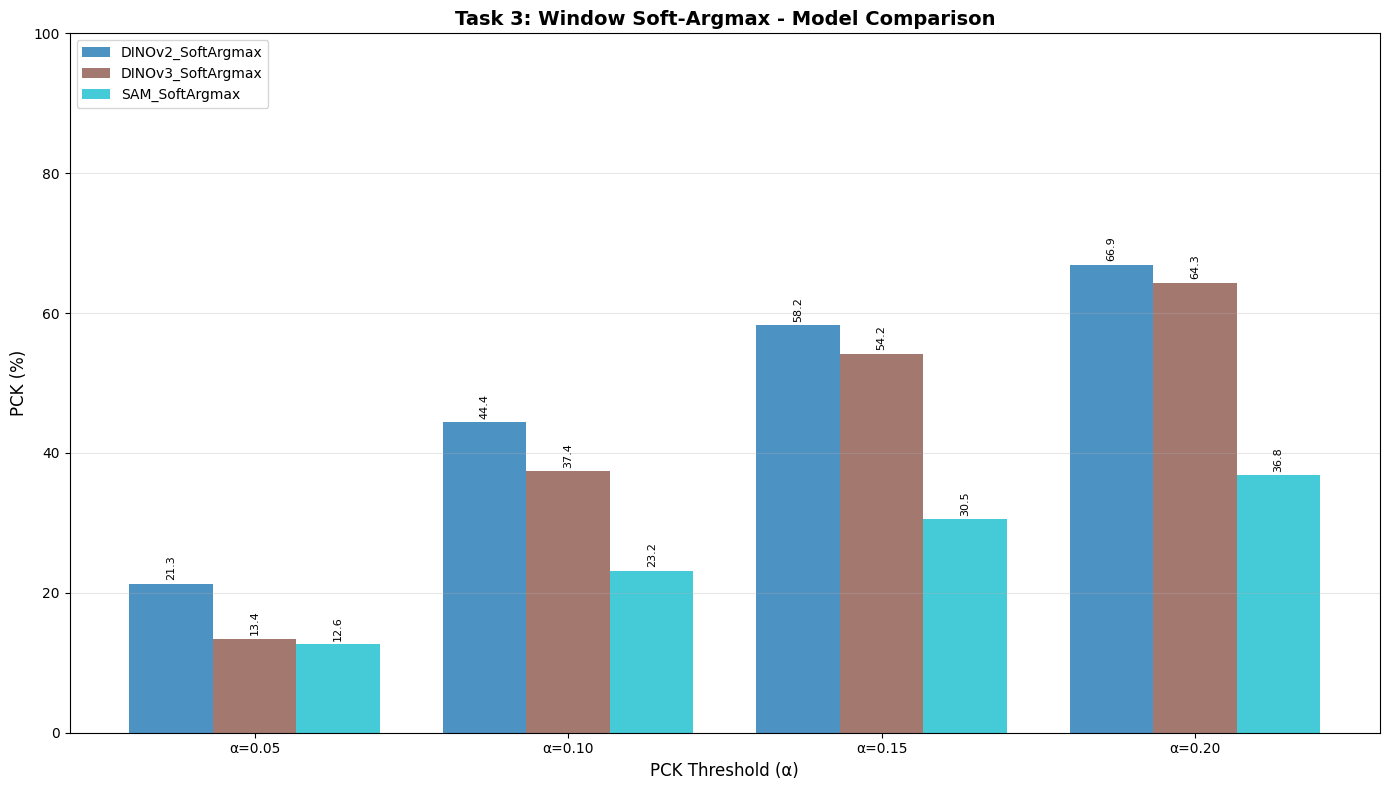

In [26]:
# Plot overall comparison
if len(all_results) > 0:
    plot_model_comparison(
        all_results,
        save_path=os.path.join(RESULTS_DIR, 'model_comparison.png')
    )

/tmp/ipython-input-1180297017.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(fontsize=10)


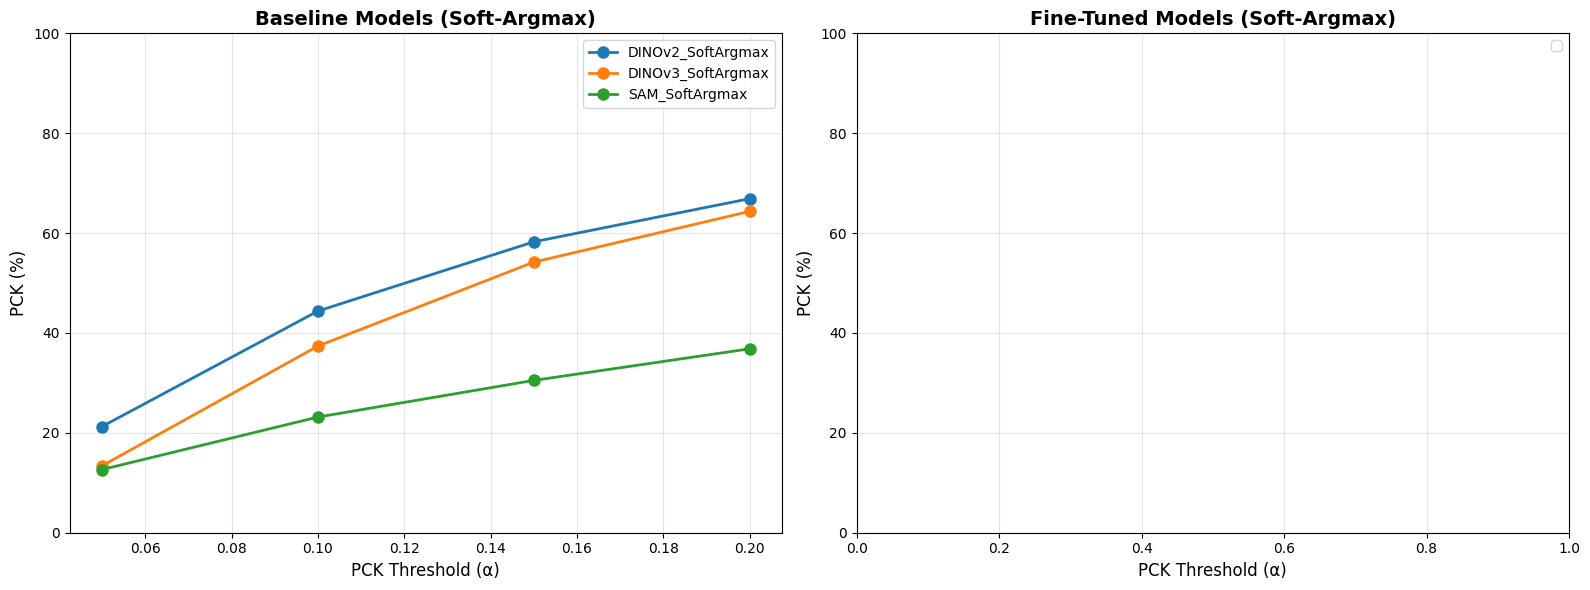

In [27]:
# Plot baseline vs fine-tuned
if len(all_results) > 1:
    plot_baseline_vs_finetuned(
        all_results,
        save_path=os.path.join(RESULTS_DIR, 'baseline_vs_finetuned.png')
    )

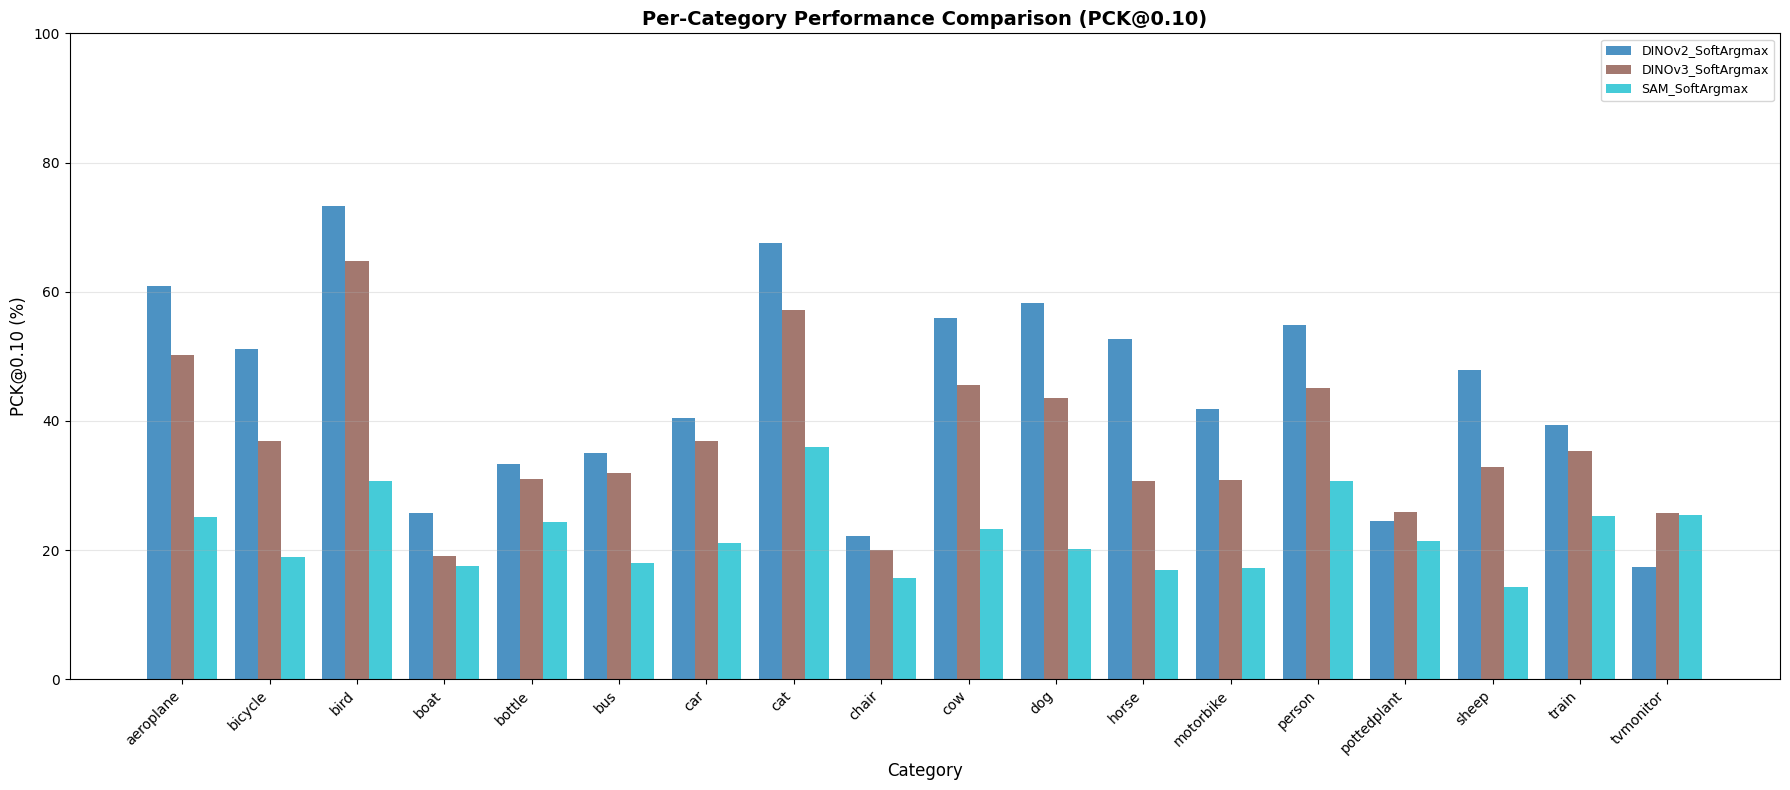

In [28]:
# Plot per-category comparison at PCK@0.10
if len(all_results) > 0:
    plot_per_category_comparison(
        all_results,
        threshold=0.10,
        save_path=os.path.join(RESULTS_DIR, 'per_category_comparison.png')
    )

## 10. Generate Individual Model Reports


Generating report for: DINOv2_SoftArgmax
📊 Generating visual report...


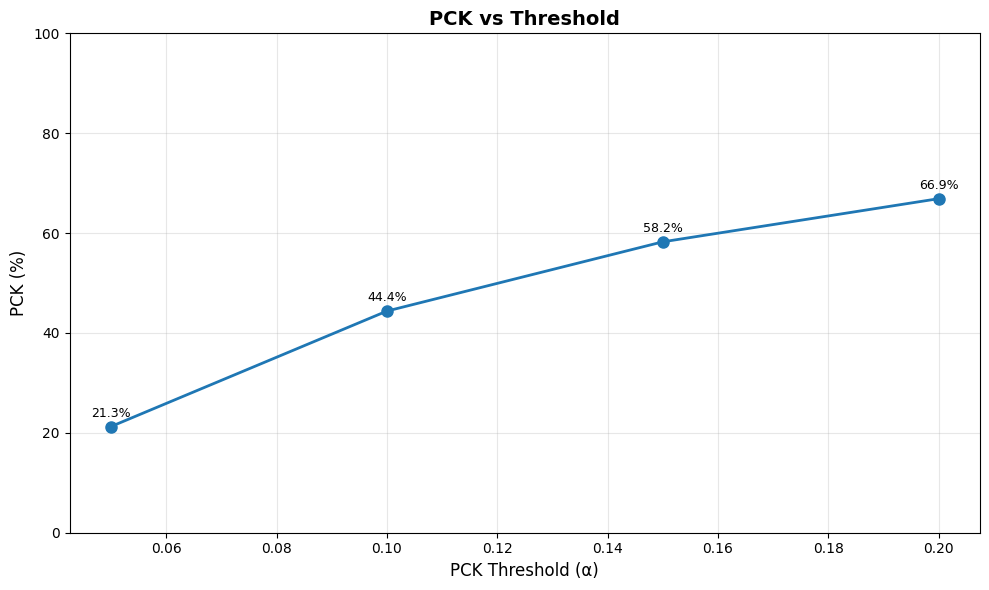

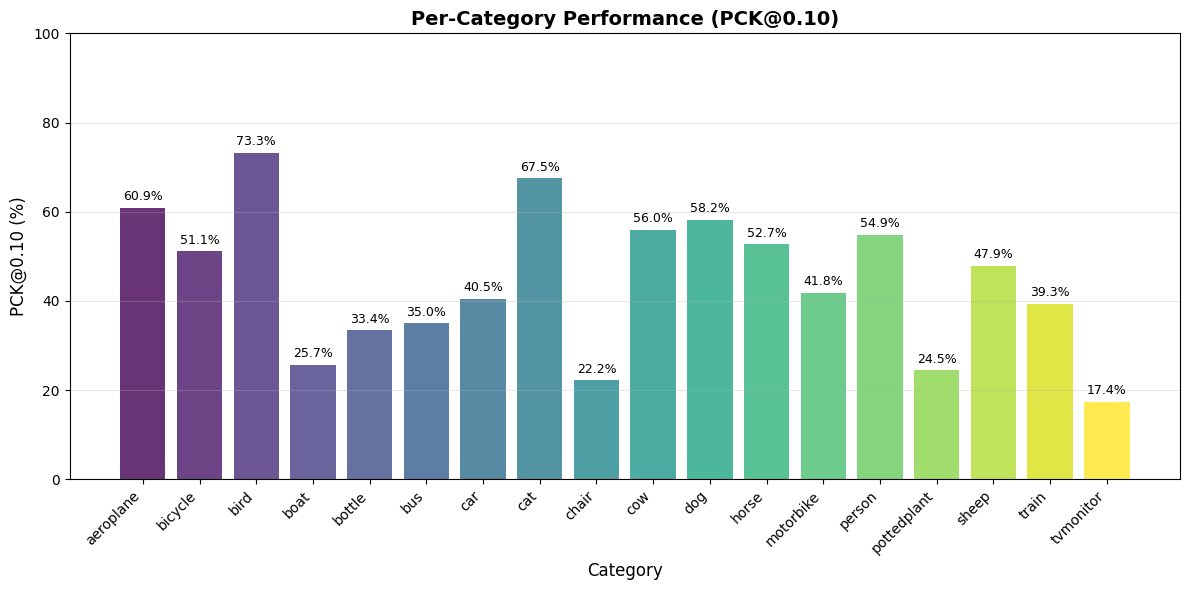

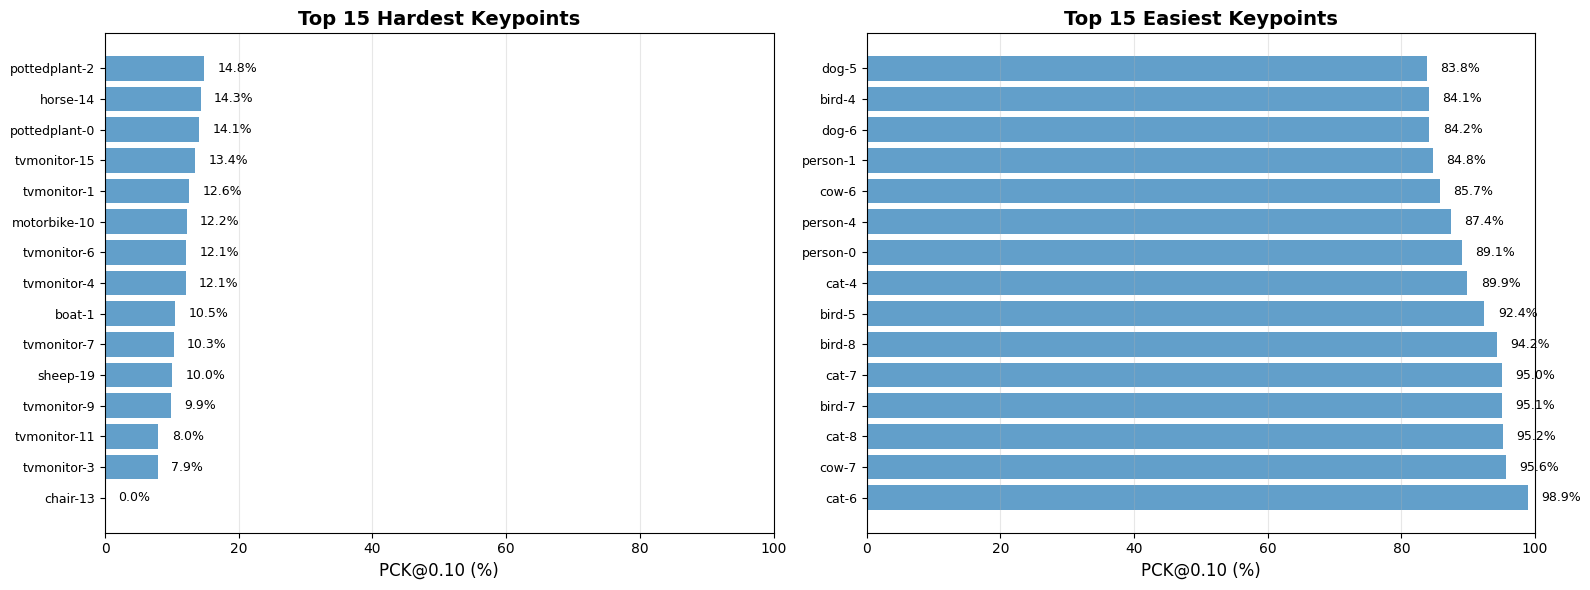

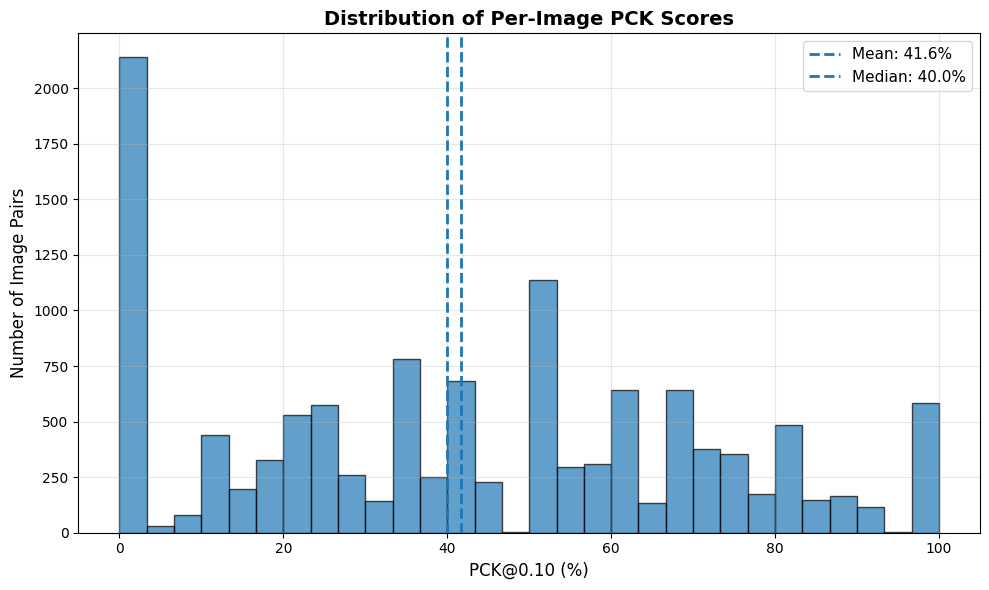

✅ Exported all metrics to ./results/task3_evaluation/DINOv2_SoftArgmax/
✅ Report generated in ./results/task3_evaluation/DINOv2_SoftArgmax/

Generating report for: DINOv3_SoftArgmax
📊 Generating visual report...


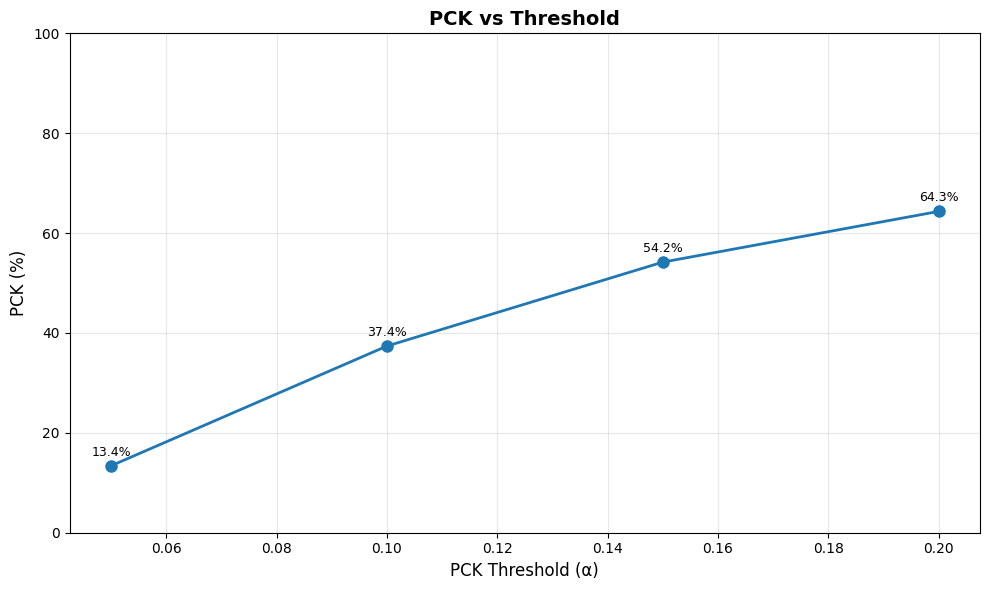

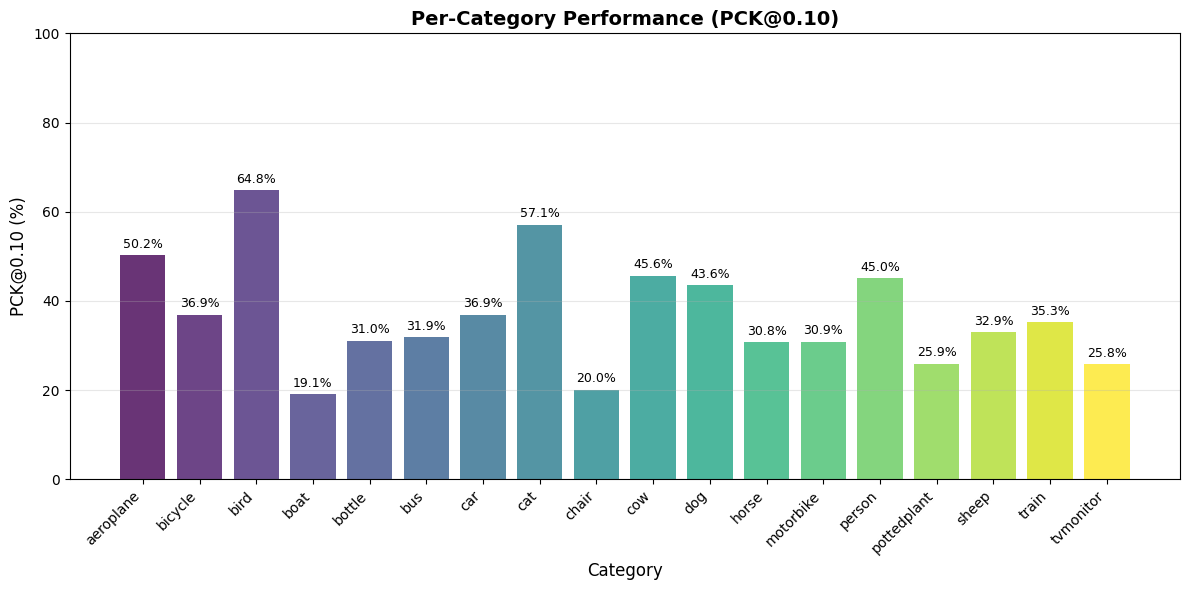

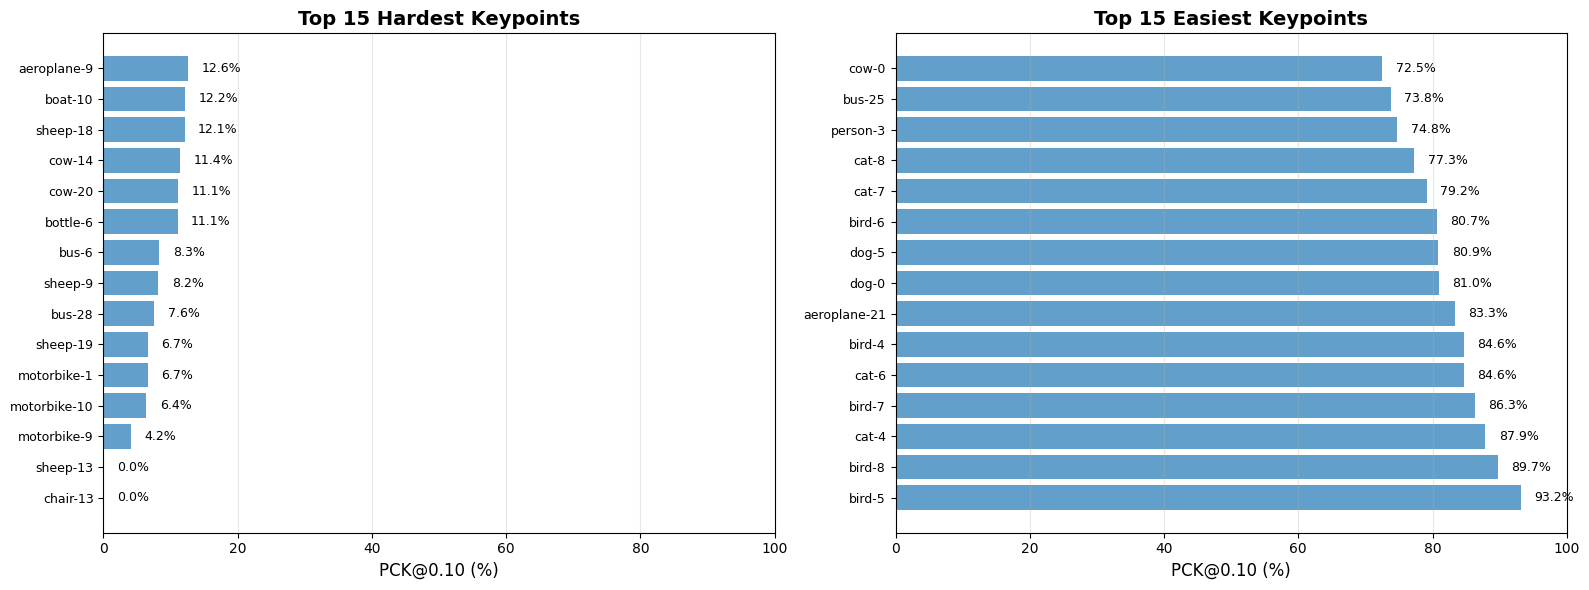

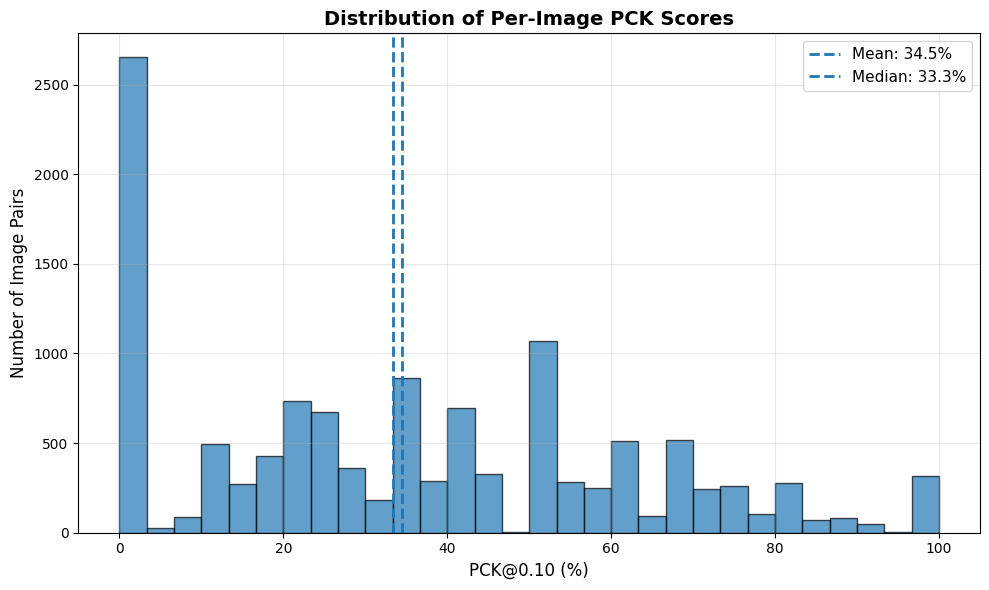

✅ Exported all metrics to ./results/task3_evaluation/DINOv3_SoftArgmax/
✅ Report generated in ./results/task3_evaluation/DINOv3_SoftArgmax/

Generating report for: SAM_SoftArgmax
📊 Generating visual report...


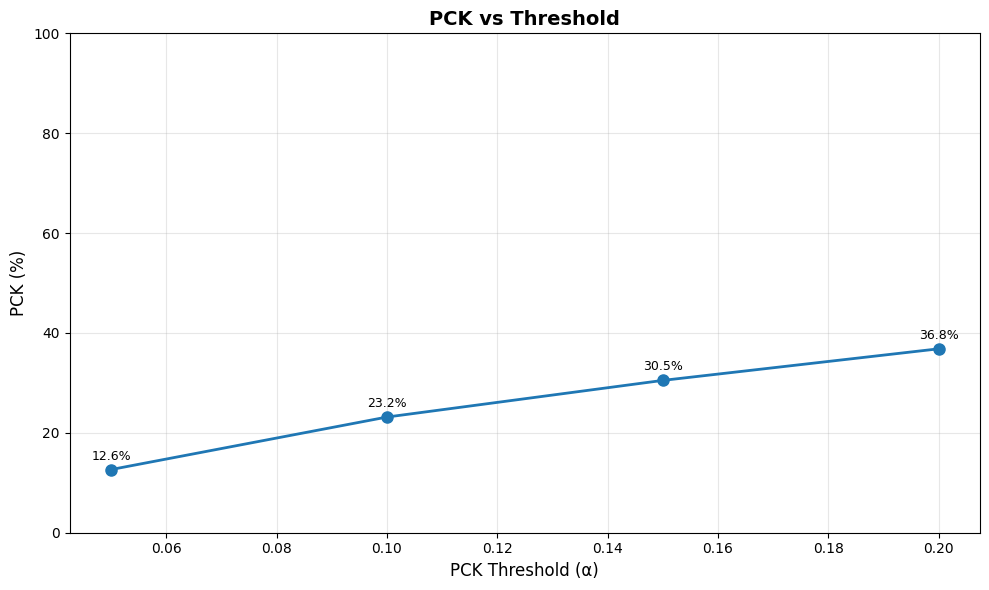

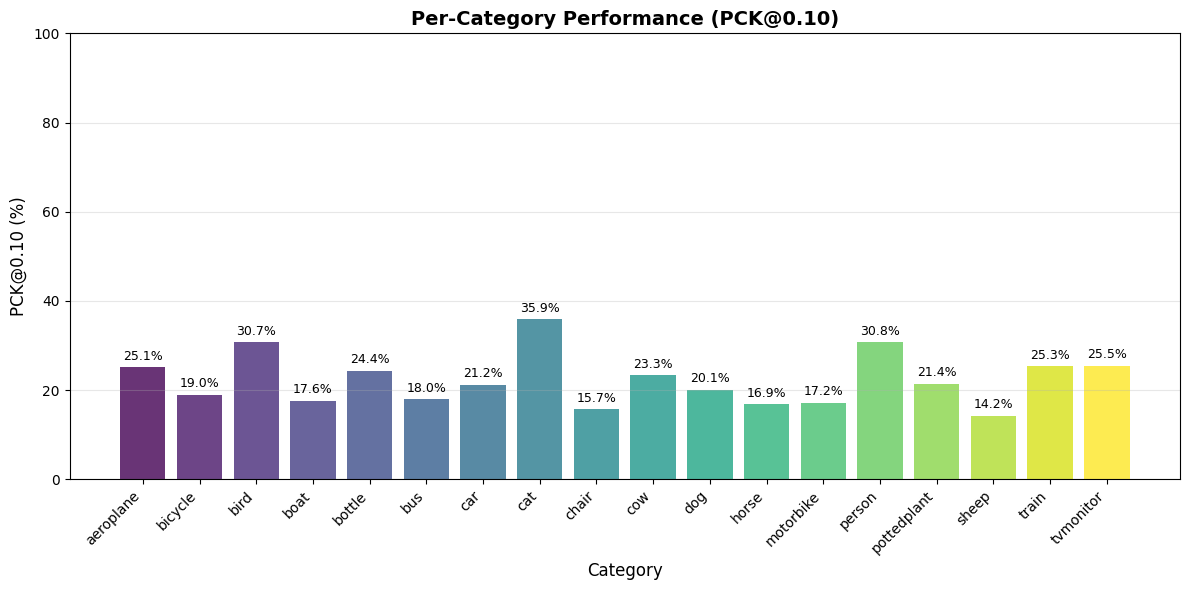

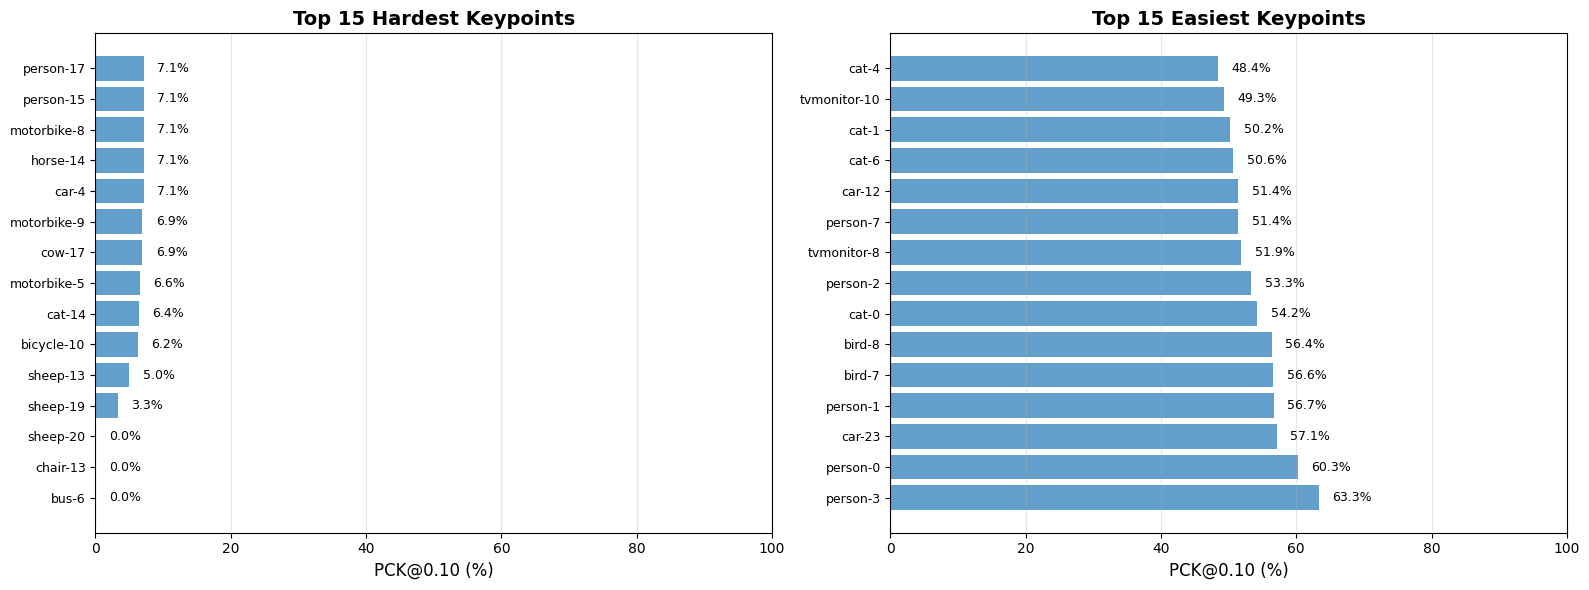

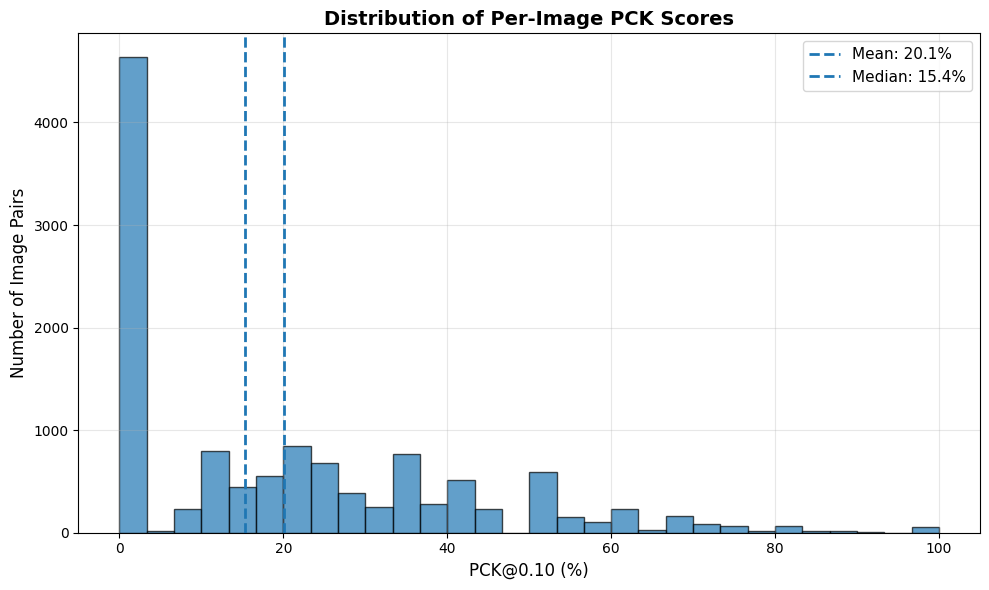

✅ Exported all metrics to ./results/task3_evaluation/SAM_SoftArgmax/
✅ Report generated in ./results/task3_evaluation/SAM_SoftArgmax/


In [29]:
# Generate detailed reports for each model
for model_name, metrics in all_results.items():
    print(f"\n{'='*70}")
    print(f"Generating report for: {model_name}")
    print('='*70)

    model_dir = os.path.join(RESULTS_DIR, model_name)
    analyzer = ResultsAnalyzer(metrics)
    analyzer.generate_report(save_dir=model_dir)

## 11. Conclusion

This notebook evaluated the Window Soft-Argmax approach for semantic correspondence on:
- Baseline models (DINOv2, DINOv3, SAM)
- Fine-tuned models (with loaded .pth checkpoints)

The Window Soft-Argmax approach provides:
1. **Sub-pixel precision** - More accurate keypoint localization
2. **Noise robustness** - Windowed softmax reduces impact of noise
3. **Better performance at strict thresholds** - Most visible at α=0.05 and α=0.10

Results are saved in the `./results/task3_evaluation/` directory.